In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt

# 定义 Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, obs, actions, rewards, next_state, next_obs, dones):
        """
        将经验存储为独立的智能体数据结构。
        """
        self.buffer.append({
            "state": state,
            "obs": obs,
            "actions": actions,
            "rewards": rewards,
            "next_state": next_state,
            "next_obs": next_obs,
            "dones": dones
        })

    def sample(self, batch_size):
        """
        随机采样 Replay Buffer，返回独立智能体的数据。
        """
        batch = random.sample(self.buffer, batch_size)
        states = [item["state"] for item in batch]
        obs = [item["obs"] for item in batch]
        actions = [item["actions"] for item in batch]
        rewards = [item["rewards"] for item in batch]
        next_states = [item["next_state"] for item in batch]
        next_obs = [item["next_obs"] for item in batch]
        dones = [item["dones"] for item in batch]
        
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(obs, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.long),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(next_obs, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

# 定义智能体网络
class AgentNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=128):
        super(AgentNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, action_dim)

    def forward(self, obs):
        x = torch.relu(self.fc1(obs))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        q_values = self.fc4(x)
        return q_values

# 定义 Attention Mixing 网络
class AttentionMixingNetwork(nn.Module):
    def __init__(self, num_agents, state_dim, hidden_dim=64):
        super(AttentionMixingNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.agent_qs_proj = nn.Linear(num_agents, hidden_dim)  # 用于对齐 agent_qs 的维度
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        self.q_combine = nn.Linear(hidden_dim, 1)

    def forward(self, agent_qs, state):
        """
        agent_qs: [batch_size, num_agents]
        state: [batch_size, state_dim]
        """
        batch_size = state.shape[0]

        # 投影到 hidden_dim
        x = torch.relu(self.fc1(state))  # [batch_size, hidden_dim]
        agent_qs_proj = self.agent_qs_proj(agent_qs)  # [batch_size, hidden_dim]

        # 注意力机制
        x, _ = self.attention(x.unsqueeze(1), agent_qs_proj.unsqueeze(1), agent_qs_proj.unsqueeze(1))

        # 全连接层
        x = torch.relu(self.fc2(x.squeeze(1)))  # [batch_size, hidden_dim]
        q_total = self.q_combine(x)  # [batch_size, 1]
        return q_total

# QMIX 主类
class QMIX:
    def __init__(self, env, state_dim, obs_dim, action_dim, num_agents, lr=1e-4, gamma=0.99, epsilon_decay=0.995):
        self.env = env
        self.state_dim = state_dim
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.num_agents = num_agents
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.05

        # 定义网络
        self.agent_network = AgentNetwork(obs_dim, action_dim)
        self.mixing_network = AttentionMixingNetwork(num_agents, state_dim)
        self.target_agent_network = AgentNetwork(obs_dim, action_dim)
        self.target_mixing_network = AttentionMixingNetwork(num_agents, state_dim)

        # 同步目标网络
        self.target_agent_network.load_state_dict(self.agent_network.state_dict())
        self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())

        # 定义优化器
        self.optimizer = optim.Adam(list(self.agent_network.parameters()) + list(self.mixing_network.parameters()), lr=lr)

        # 初始化 Replay Buffer
        self.replay_buffer = ReplayBuffer(50000)

    def select_action(self, obs):
        """
        动作选择策略，结合 ε-greedy 和集中式策略网络。
        """
        actions = []
        if random.random() < self.epsilon:
            # 随机选择动作
            actions = [np.random.randint(0, self.action_dim) for _ in range(self.num_agents)]
        else:
            # 使用策略网络选择动作
            obs_tensor = torch.tensor(obs, dtype=torch.float32)  # [num_agents, obs_dim]
            q_values = self.agent_network(obs_tensor)  # [num_agents, action_dim]
            actions = q_values.argmax(dim=1).tolist()

        # 更新 epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
        return actions

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        # 从 Replay Buffer 中采样
        states, obs, actions, rewards, next_states, next_obs, dones = self.replay_buffer.sample(batch_size)

        # 当前 Q 值
        q_values = []
        for agent in range(self.num_agents):
            agent_obs = obs[:, agent, :]
            agent_actions = actions[:, agent]
            agent_q = self.agent_network(agent_obs)
            q_values.append(agent_q.gather(1, agent_actions.unsqueeze(-1)).squeeze(-1))
        q_values = torch.stack(q_values, dim=1)  # [batch_size, num_agents]

        # Mixing 网络合成全局 Q 值
        q_total = self.mixing_network(q_values, states)

        # 目标 Q 值
        with torch.no_grad():
            target_q_values = []
            for agent in range(self.num_agents):
                agent_next_obs = next_obs[:, agent, :]
                target_agent_q = self.target_agent_network(agent_next_obs)
                target_q_values.append(torch.max(target_agent_q, dim=1)[0])
            target_q_values = torch.stack(target_q_values, dim=1)  # [batch_size, num_agents]
            target_q_total = self.target_mixing_network(target_q_values, next_states)

        targets = rewards.sum(dim=1) + self.gamma * (1 - dones) * target_q_total.squeeze(-1)
        loss = nn.MSELoss()(q_total.squeeze(-1), targets)

        # 更新网络
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target_networks(self):
        self.target_agent_network.load_state_dict(self.agent_network.state_dict())
        self.target_mixing_network.load_state_dict(self.mixing_network.state_dict())

# 训练主循环
def train_qmix(env, num_episodes=1000, batch_size=32, target_update_interval=100):
    state_dim = env.get_state().shape[0]
    obs_dim = env.observation_space(env.agents[0]).shape[0]
    action_dim = env.action_space(env.agents[0]).n
    num_agents = len(env.agents)

    qmix = QMIX(env, state_dim, obs_dim, action_dim, num_agents)

    rewards_history = []  # 用于记录每个 Episode 的总奖励
    q_values_history = []  # 用于记录每个 Episode 的总 Q 值

    with tqdm(total=num_episodes, desc="Training Progress") as pbar:
        for episode in range(num_episodes):
            obs = env.reset()
            state = env.get_state()
            done = False
            episode_reward = 0
            episode_q_value = 0
            steps = 0

            while not done:
                actions = {agent: qmix.select_action([obs[agent]])[0] for agent in env.agents}
                next_obs, rewards, dones, _ = env.step(actions)
                next_state = env.get_state()

                # 存储到 Replay Buffer
                qmix.replay_buffer.add(
                    state, 
                    np.array([obs[agent] for agent in env.agents]),
                    np.array([actions[agent] for agent in env.agents]),
                    np.array([rewards[agent] for agent in env.agents]),
                    next_state,
                    np.array([next_obs[agent] for agent in env.agents]),
                    float(all(dones.values()))
                )

                obs = next_obs
                state = next_state
                episode_reward += sum(rewards.values())
                steps += 1

                # 训练
                loss = qmix.train(batch_size)

                # 记录每步的 Q 值
                if loss is not None:
                    q_values = [qmix.agent_network(torch.tensor(obs[agent], dtype=torch.float32)).max().item() for agent in env.agents]
                    episode_q_value += sum(q_values)

                if all(dones.values()):
                    break

            rewards_history.append(episode_reward)
            q_values_history.append(episode_q_value / steps if steps > 0 else 0)

            if episode % target_update_interval == 0:
                qmix.update_target_networks()

            # 更新 tqdm
            pbar.set_postfix({
                "Reward": episode_reward,
                "Q Value": q_values_history[-1]
            })
            pbar.update(1)

    return qmix, rewards_history, q_values_history

def plot_training_results(rewards_history, q_values_history):
    # 绘制 Reward 曲线
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history, label="Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制 Q 值曲线
    plt.figure(figsize=(12, 6))
    plt.plot(q_values_history, label="Q Value", color="orange")
    plt.xlabel("Episode")
    plt.ylabel("Average Q Value")
    plt.title("Average Q Value over Episodes")
    plt.legend()
    plt.grid()
    plt.show()

/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]/var/folders/8l/jgps2kqd6v58l257c5xc_2h00000gn/T/ipykernel_82888/3912836129.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608617468/work/torch/csrc/utils/tensor_new.cpp:277.)
  obs_tensor = torch.tensor(obs, dtype=torch.float32)  # [num_agents, obs_dim]
Training Progress: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s, Reward=-1.86e+6, Q Value=2.02e+4]


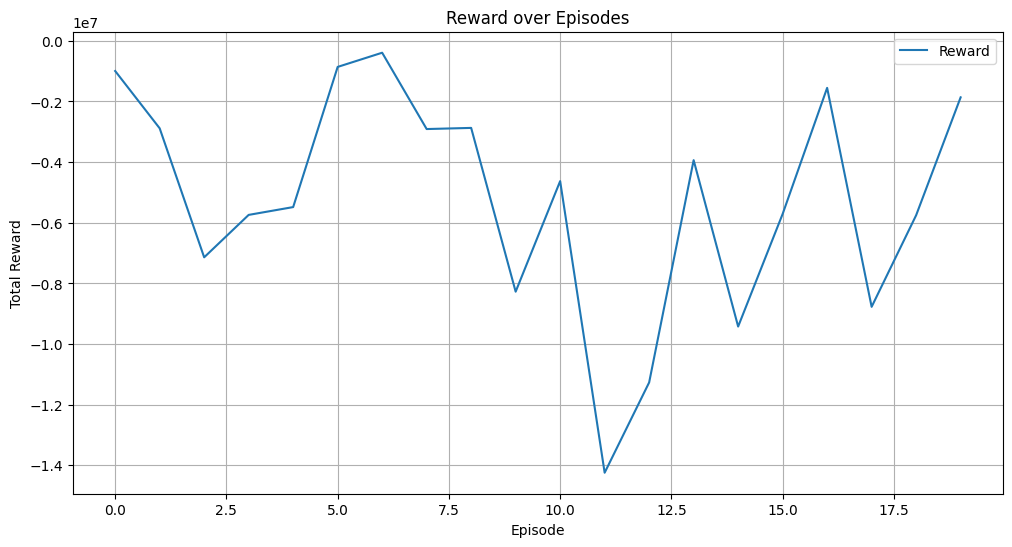

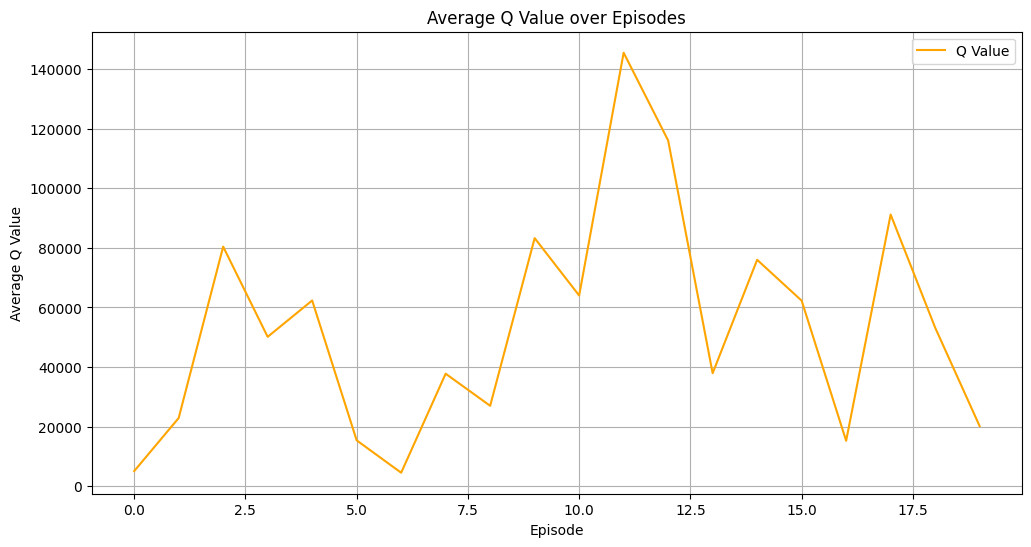

In [2]:
from env.MAenv import CustomMAEnvironment
# 创建环境
env = CustomMAEnvironment()

# 训练 QMIX
# 训练 QMIX
qmix_trained, rewards_history, q_values_history = train_qmix(env, num_episodes=20)

# 绘制训练结果
plot_training_results(rewards_history, q_values_history)